In [ ]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: ignored

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
import matplotlib.gridspec as gridspec
from keras.models import model_from_json
import glob

In [4]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading of WP_Net model successfully...")
        return model
    except Exception as e:
        print(e)

In [5]:
wpod_net_path = "/content/drive/My Drive/ailicense/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading of WP_Net model successfully...


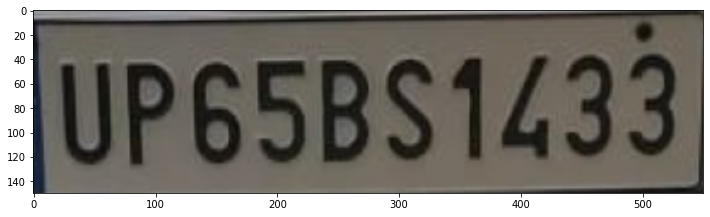

In [6]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=165):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

#test_image_path = "test_2.jpg"
test_image_path = "/content/1.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
plt.imshow(LpImg[0])
plt.savefig("/content/drive/My Drive/ailicense/croppedplate2.jpg",dpi=300)


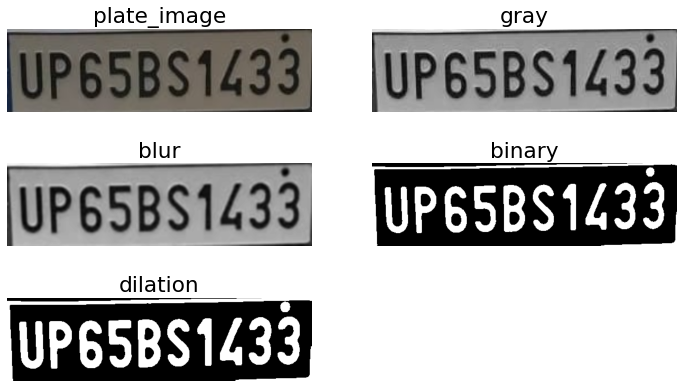

In [7]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

In [8]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(plate_image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('/content/contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [9]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('/content/contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

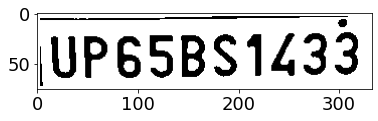

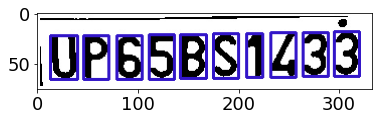

In [10]:
img = plate_image
char = segment_characters(img)

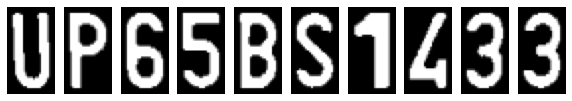

In [11]:
fig = plt.figure(figsize=(10,6))
grid = gridspec.GridSpec(ncols=len(char),nrows=1,figure=fig)

for i in range(len(char)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(char[i],cmap="gray")
plt.savefig("/content/drive/My Drive/ailicense/seperate_char_image.jpg")

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

In [13]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/ailicense/dataset_characters.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


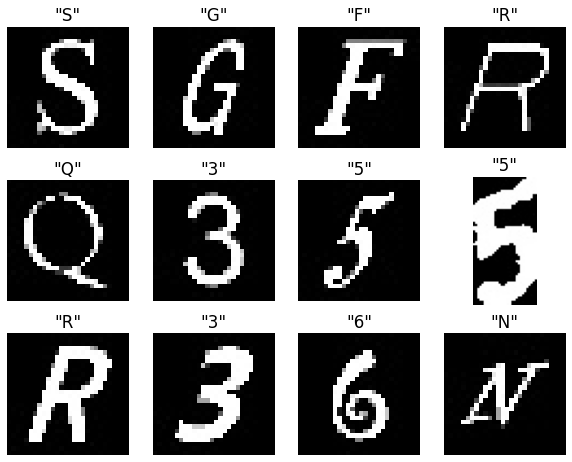

In [14]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("/content/drive/My Drive/ailicense/Visualize_Image_dataset.jpg",dpi=300)

In [15]:
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('/content/drive/My Drive/ailicense/license_Plate_character_classes.npy', lb.classes_)

[INFO] Find 37623 images with 36 classes


In [16]:
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [17]:
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [18]:
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        model.summary()
    return model

In [19]:
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 40, 40, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="/content/drive/My Drive/ailicense/License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
529/529 [==============================] - 923s 2s/step - loss: 1.4111 - accuracy: 0.6330 - val_loss: 1.3274 - val_accuracy: 0.6527

Epoch 00001: saving model to /content/drive/My Drive/ailicense/License_character_recognition.h5
Epoch 2/30
529/529 [==============================] - 933s 2s/step - loss: 0.4466 - accuracy: 0.8822 - val_loss: 0.6275 - val_accuracy: 0.8368

Epoch 00002: saving model to /content/drive/My Drive/ailicense/License_character_recognition.h5
Epoch 3/30
529/529 [==============================] - 995s 2s/step - loss: 0.3120 - accuracy: 0.9167 - val_loss: 0.3482 - val_accuracy: 0.9075

Epoch 00003: saving model to /content/drive/My Drive/ailicense/License_character_recognition.h5
Epoch 4/30
529/529 [==============================] - 990s 2s/step - loss: 0.2435 - accuracy: 0.9329 - val_loss: 0.2302 - val_accuracy: 0.9336

Epoch 00004: saving model to /content/drive/My Drive/ailicense/License_character_recognition.h5
Epoch 5/30
529/529 [====================

ValueError: ignored

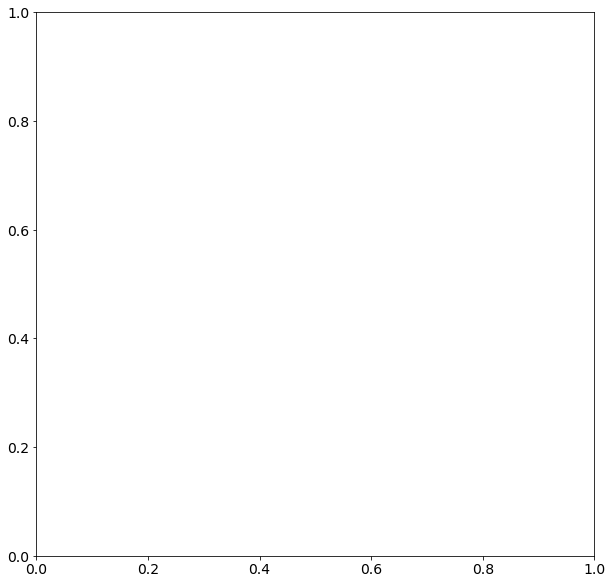

In [165]:
fig1=plt.figure(figsize=(10,10))
train_acc = result.history['accuracy']
acc_val = result.history['val_accuracy']
epochs = range(0,30)
plt.plot(epochs, train_acc)
plt.plot(epochs, acc_val)
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Testing'], loc='lower right')
#plt.show()

fig2 = plt.figure(figsize=(10,10))
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(0,30)
plt.plot(epochs, loss_train)
plt.plot(epochs, loss_val)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Testing'], loc='upper right')
#plt.show()

#plt.savefig("/content/drive/My Drive/ailicense/Training_result_accuracy.jpg",dpi=300)
#plt.savefig("/content/drive/My Drive/ailicense/Training_result_loss.jpg",dpi=300)

In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/ailicense/MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [ ]:
json_file = open('/content/drive/My Drive/ailicense/MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/My Drive/ailicense/License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('/content/drive/My Drive/ailicense/license_Plate_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [ ]:
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

MH12DE1A33


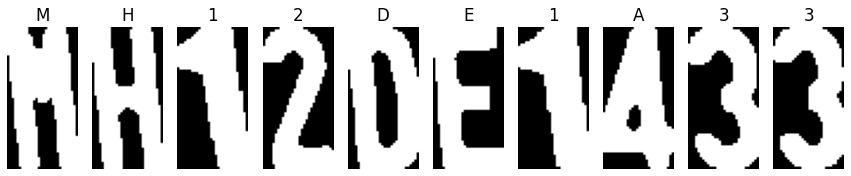

In [ ]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)

In [ ]:
import csv

header='Vechile Number'
filename='sample.csv'
filesize=0
if(os.path.exists(filename) and os.path.isfile(filename)):
    filesize=os.stat(filename).st_size
f=open(filename,'a')
if(filesize == 0):
    f.write('%s\n' % header)
f.write('%s\n' % final_string)
f.close()